In [1]:
import pandas as pd
from sqlalchemy import create_engine
from tqdm import tqdm
import urllib
from sqlalchemy import text

import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter

from PIL import ImageEnhance, Image
tqdm.pandas()



In [2]:
conn_string_odbc="Driver={ODBC Driver 18 for SQL Server};Server=tcp:smartspace.database.windows.net,1433;Database=connectionspace;Uid=stats170-G6;Pwd=cro-r5sweDlVay5t=eta;Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;"
params = urllib.parse.quote_plus(conn_string_odbc)
conn_str_formatted = 'mssql+pyodbc:///?odbc_connect={}'.format(params)
engine = create_engine(conn_str_formatted)


In [3]:
# Fetch lctr_complete table
conn = engine.connect()

query = text("SELECT * FROM lctr_complete")
results = conn.execute(query)

rows = results.fetchall()
cols = results.keys()
df_processed_data = pd.DataFrame(rows, columns=cols)

conn.close()

df_processed_data.head()

observation_id                                macAddress          sensor  \
0          699761  cf170b6d02af1925d1c0710ca09b10fbe86df3f8  3144-clwa-4099   
1          699762  c0b682bd56797b25ed58c0641842ad04fc100d99  3144-clwa-4231   
2          699763  8a82ee081af3c5af0544440152f949c4525cd0f8  3143-clwa-3231   
3          699764  99b4615fbd8412eb25e4dc19e98c0497547a5a60  3145-clwa-5019   
4          699765  f4a6517603e69e48c8944758f0cd35ac6b7c58cb  3142-clwa-2209   

      connection_time  predicted_region_id predicted_region_name  
0 2017-09-25 15:38:48                  302        3144-clwa-4099  
1 2017-09-25 15:39:05                  295        3144-clwa-4231  
2 2017-09-25 15:39:05                  222        3143-clwa-3231  
3 2017-09-25 15:39:10                  374        3145-clwa-5019  
4 2017-09-25 15:39:10                  146        3142-clwa-2209

In [4]:
# coordinates
floor_coordinates = {
    1: {'3141-clwa-1100': (280,147),'3141-clwa-1200': (390,216),'3141-clwa-1300': (485,440),
    '3141-clwa-1412': (300,633),'3141-clwa-1420': (151,649),'3141-clwa-1422': (151,798),'3141-clwa-1423': (179,931),
    '3141-clwa-1425': (338,921),'3141-clwa-1427': (490,931),'3141-clwa-1429': (608,913),'3141-clwa-1431': (802,921),
    '3141-clwa-1433': (915,880),'3141-clwa-1500': (787,789),'3141-clwa-1600': (1150,906),'3141-clwb-1100': (290,427),
    '3141-clwb-1200': (497,88),'3141-clwb-1300': (367,301),'3141-clwc-1100': (50,213),'3141-clwd-1100': (53,440),
    '3141-clwe-1100': (52,340)},
    2: {'3142-clwa-2019': (194,536),'3142-clwa-2039': (195,681),'3142-clwa-2051': (444,667),
    '3142-clwa-2059': (590,681),'3142-clwa-2065': (737,664),'3142-clwa-2099': (766,541),'3142-clwa-2209': (168,300),
    '3142-clwa-2219': (151,122),'3142-clwa-2231': (326,188)},
    3: {'3143-clwa-3019': (180,535),'3143-clwa-3039': (243,687),
    '3143-clwa-3051': (465,680),'3143-clwa-3059': (602,672),'3143-clwa-3065': (753,695),'3143-clwa-3099': (785,600),
    '3143-clwa-3209': (140,305),'3143-clwa-3219': (167,165),'3143-clwa-3231': (342,127)},
    4: {'3144-clwa-4019': (183,534),
    '3144-clwa-4039': (190,680),'3144-clwa-4051': (454,696),'3144-clwa-4059': (573,627),'3144-clwa-4065': (756,700),
    '3144-clwa-4099': (781,599),'3144-clwa-4209': (175,302),'3144-clwa-4219': (152,129),'3144-clwa-4231': (341,127)},
    5: {'3145-clwa-5019': (175,542),'3145-clwa-5039': (190,680),'3145-clwa-5051': (454,696),'3145-clwa-5059': (573,627),
    '3145-clwa-5065': (756,700),'3145-clwa-5099': (781,599),'3145-clwa-5209': (175,302),'3145-clwa-5219': (152,129),
    '3145-clwa-5231': (341,127)},
    6: {'3146-clwa-6011': (369,380),'3146-clwa-6029': (178,573),'3146-clwa-6049': (443,714),
    '3146-clwa-6122': (819,696),'3146-clwa-6131': (637,601),'3146-clwa-6217': (110,228),'3146-clwa-6219': (210,230)}
}


In [5]:
#Quarter

from datetime import datetime
calendar17_18_19 = {
    "summer17": [datetime(2017, 6, 26), datetime(2017, 9, 13), datetime(2017, 9, 25)],
    "f17": [datetime(2017, 9, 25), datetime(2017, 12, 15), datetime(2018, 1,  3)],
    "w18": [datetime(2018, 1,  3), datetime(2018,  3, 23), datetime(2018, 3, 28)],
    "s18": [datetime(2018, 3, 28), datetime(2018,  6, 15), datetime(2018, 9, 24)],
    "summer18": [datetime(2018, 6, 25), datetime(2018, 9, 12), datetime(2018, 9, 24)],
    "f18": [datetime(2018, 9, 24), datetime(2018, 12, 14), datetime(2019, 1,  2)],
    "w19": [datetime(2019, 1,  2), datetime(2019,  3, 22), datetime(2019, 3, 27)],
    "s19": [datetime(2019, 3, 27), datetime(2019,  6, 14), datetime(2019, 6, 24)]
    }


In [6]:
# Merge quarters depending if break is desired
for quarter, date_range in calendar17_18_19.items():
    df_processed_data.loc[df_processed_data["connection_time"].between(date_range[0], date_range[1], inclusive="both"   ), "quarter"] = quarter
    df_processed_data.loc[df_processed_data["connection_time"].between(date_range[1], date_range[2], inclusive="neither"), "quarter"] = quarter + "_break"

df_processed_data["quarter"] = df_processed_data.quarter.str.replace("_break", "")
quarter_order = ['f17', 'w18', 's18', 
                 'f18', 'w19', 's19']

In [7]:
# Function to create heatmap
def create_heatmap(ax, df, floor, title, coordinates, image_path, cmap):
    # Enhance the contrast of the original image
    image = Image.open(image_path)
    enhancer = ImageEnhance.Contrast(image)
    enhanced_image = enhancer.enhance(2.0)  # Increase the contrast level
    enhanced_image = np.array(enhanced_image)

    # Filter dataframe for the specified floor using the 4th from last character
    df_floor = df[df['predicted_region_name'].astype(str).str[-4] == str(floor)]
    
    # Group by 'predicted_region_name' and count entries
    df_room_counts = df_floor['predicted_region_name'].value_counts().reset_index()
    df_room_counts.columns = ['predicted_region_name', 'counts']
    
    room_counts_dict = dict(zip(df_room_counts['predicted_region_name'], df_room_counts['counts']))
    print(room_counts_dict)
    data = np.zeros((enhanced_image.shape[0], enhanced_image.shape[1]))

    for AP, coords in coordinates.items():
        y, x = coords
        v = 0
        if AP in room_counts_dict:
            v = room_counts_dict[AP]
        data[x-40: x+40, y-40: y+40] = v

    sigma = 100  # Adjust the sigma value as needed for desired smoothness
    smoothed_data = gaussian_filter(data, sigma=sigma)

    ax.imshow(enhanced_image, alpha=0.9)  # Display the enhanced image with higher transparency
    ax.imshow(smoothed_data, alpha=0.6, extent=(0, enhanced_image.shape[1], enhanced_image.shape[0], 0), cmap=cmap, interpolation='spline16')

    ax.set_title(title)
    ax.axis('off')


In [10]:
# Main function to generate heatmaps for a given floor
def generate_heatmaps(df, floor, cmap):
    coordinates = floor_coordinates[floor]
    file_path = f"DBH {floor}F.png"

    # Calculate number of rows needed
    num_quarters = len(quarter_order)
    num_cols = 3
    num_rows = (num_quarters + num_cols - 1) // num_cols 

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))  

    axs = axs.flatten()

    for ax, quarter in zip(axs, quarter_order):
        df_quarter = df[df['quarter'] == quarter]
        create_heatmap(ax, df_quarter, floor, f"{quarter}", coordinates, file_path, cmap)

    plt.tight_layout()
    plt.show()


{'3141-clwe-1100': 344287, '3141-clwc-1100': 318447, '3141-clwa-1412': 267398, '3141-clwb-1100': 211127, '3141-clwa-1100': 210848, '3141-clwa-1300': 157831, '3141-clwa-1200': 112155, '3141-clwa-1433': 108693, '3141-clwa-1427': 103129, '3141-clwd-1100': 102154, '3141-clwa-1420': 91865, '3141-clwa-1429': 89513, '3141-clwb-1300': 77040, '3141-clwa-1425': 65875, '3141-clwa-1431': 65490, '3141-clwa-1422': 64312, '3141-clwa-1423': 62466, '3141-clwb-1200': 59439}
{'3141-clwe-1100': 168834, '3141-clwc-1100': 162010, '3141-clwa-1412': 138929, '3141-clwa-1100': 123999, '3141-clwb-1100': 98191, '3141-clwd-1100': 72739, '3141-clwa-1433': 62804, '3141-clwa-1431': 59684}
{}
{}
{}
{'3141-clwa-1500': 23796, '3141-clwa-1100': 22827, '3141-clwa-1600': 16295, '3141-clwa-1412': 14707, '3141-clwa-1420': 11704, '3141-clwa-1429': 11361, '3141-clwa-1423': 7994, '3141-clwa-1433': 6512, '3141-clwa-1300': 5695, '3141-clwa-1422': 4606, '3141-clwa-1200': 3388, '3141-clwa-1425': 3238, '3141-clwa-1427': 3237, '3141-

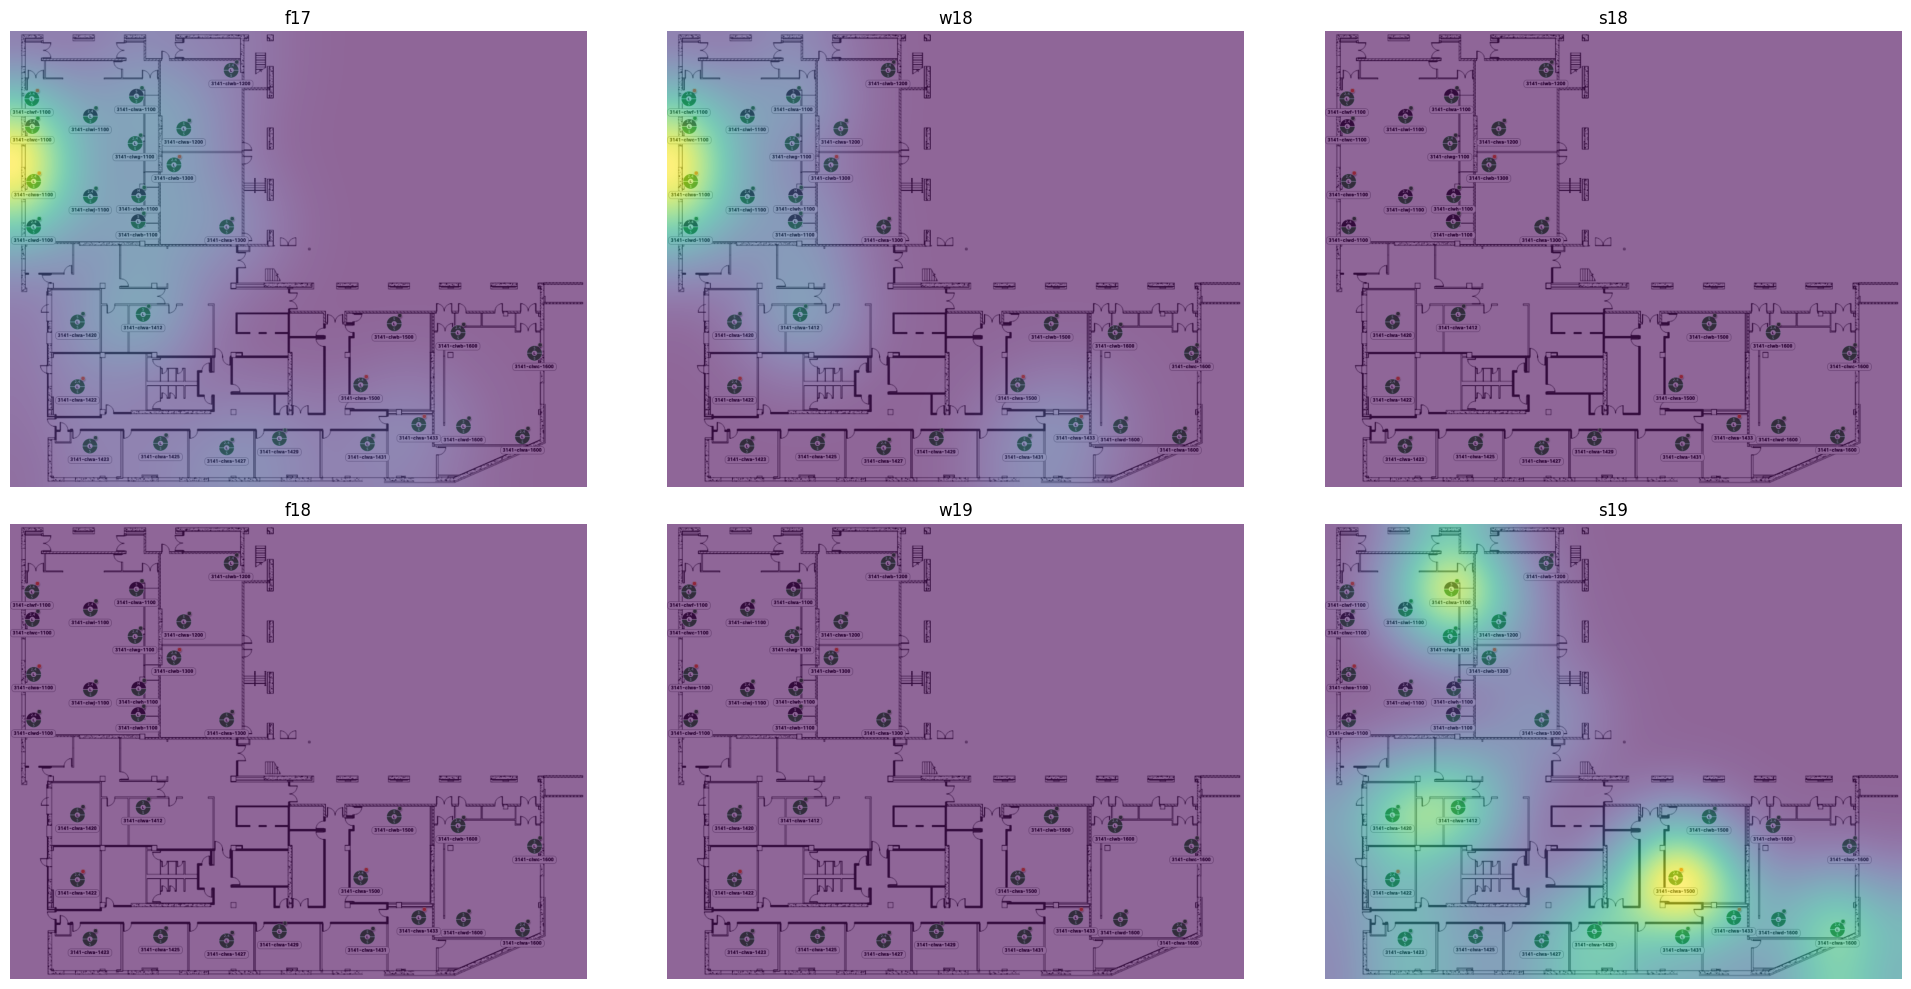

{'3142-clwa-2019': 160753, '3142-clwa-2209': 146751, '3142-clwa-2231': 78600, '3142-clwa-2065': 53887, '3142-clwa-2099': 50667, '3142-clwa-2051': 50547, '3142-clwa-2059': 43923, '3142-clwa-2219': 21663, '3142-clwa-2039': 20698}
{'3142-clwa-2209': 211882, '3142-clwa-2019': 179281, '3142-clwa-2231': 123842, '3142-clwa-2051': 80729, '3142-clwa-2099': 74065, '3142-clwa-2065': 65761, '3142-clwa-2059': 53827, '3142-clwa-2219': 48466, '3142-clwa-2039': 29610}
{'3142-clwa-2209': 311626, '3142-clwa-2231': 128015, '3142-clwa-2219': 126388, '3142-clwa-2019': 123706, '3142-clwa-2051': 97089, '3142-clwa-2099': 87083, '3142-clwa-2065': 71378, '3142-clwa-2059': 68387, '3142-clwa-2039': 32193}
{'3142-clwa-2209': 194141, '3142-clwa-2019': 117743, '3142-clwa-2219': 97073, '3142-clwa-2051': 86914, '3142-clwa-2231': 73762, '3142-clwa-2059': 65845, '3142-clwa-2099': 64126, '3142-clwa-2065': 52100, '3142-clwa-2039': 18559}
{'3142-clwa-2209': 170644, '3142-clwa-2019': 132656, '3142-clwa-2219': 101713, '3142-

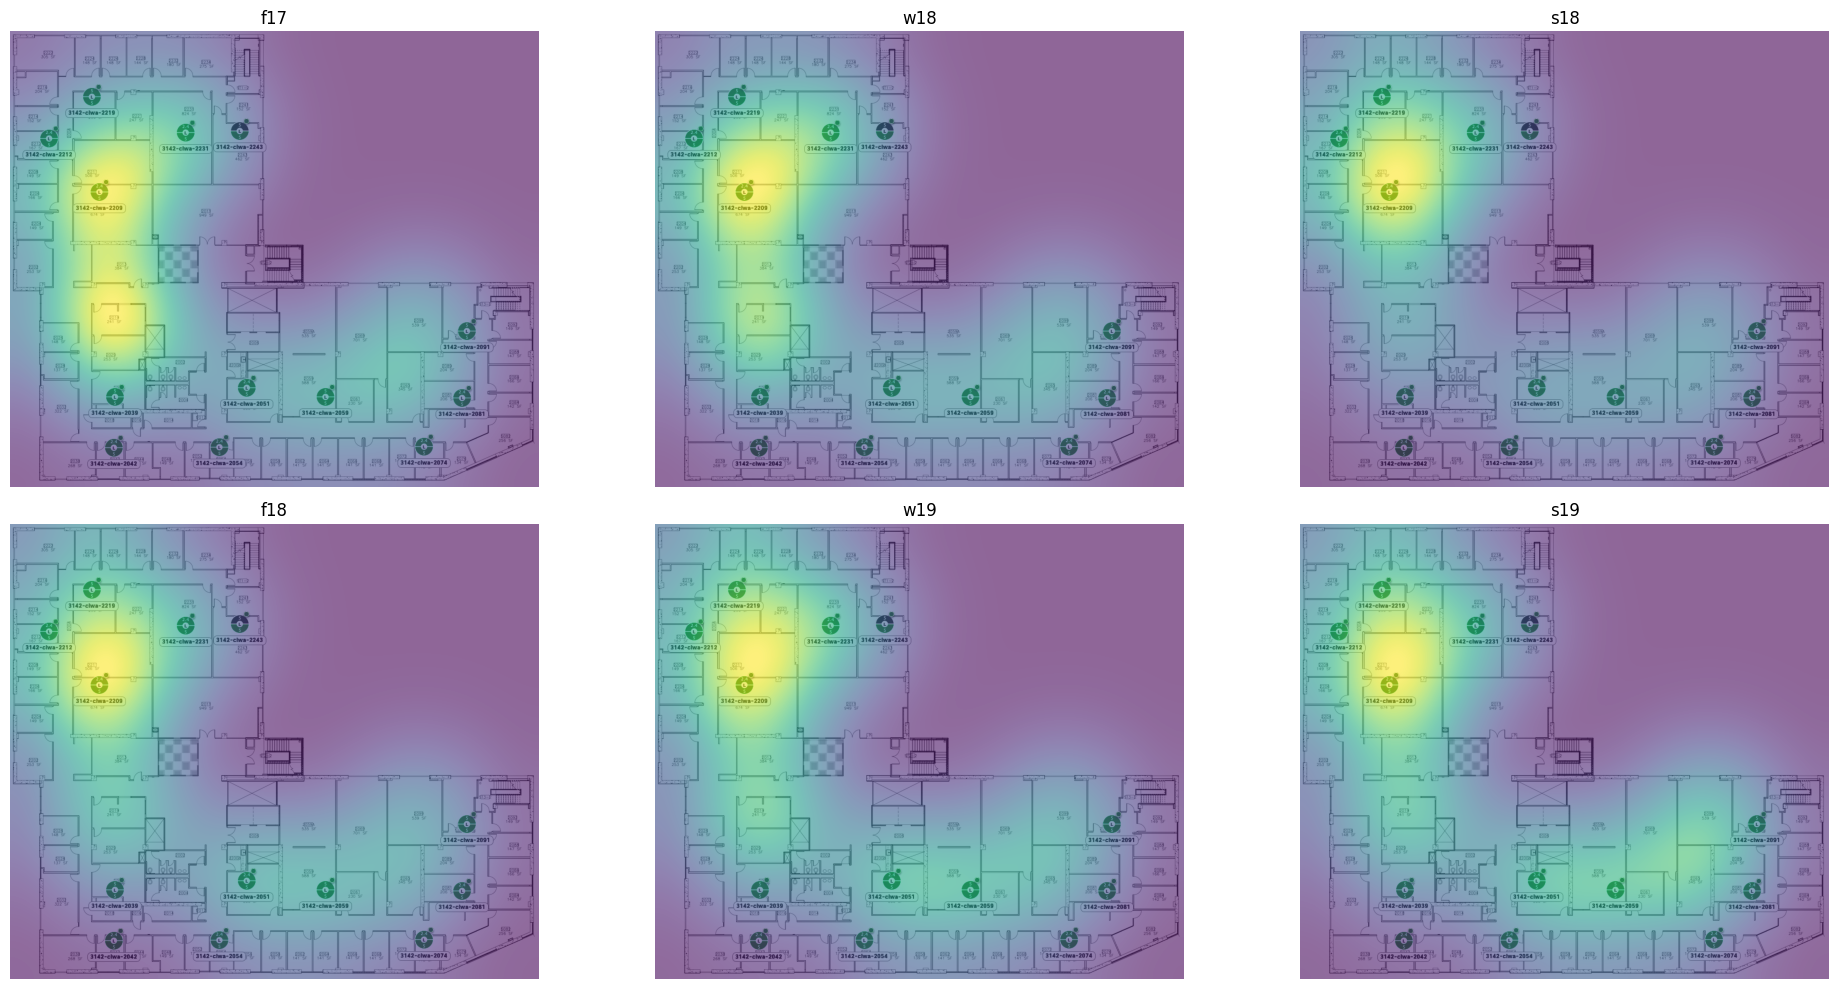

{'3143-clwa-3039': 267650, '3143-clwa-3051': 56677, '3143-clwa-3099': 55821, '3143-clwa-3019': 54005, '3143-clwa-3231': 52743, '3143-clwa-3059': 52007, '3143-clwa-3065': 32620, '3143-clwa-3219': 29669, '3143-clwa-3209': 22252}
{'3143-clwa-3039': 384516, '3143-clwa-3051': 71833, '3143-clwa-3019': 61161, '3143-clwa-3059': 58473, '3143-clwa-3231': 54175, '3143-clwa-3065': 45890, '3143-clwa-3099': 45607, '3143-clwa-3209': 24812, '3143-clwa-3219': 23068}
{'3143-clwa-3039': 359874, '3143-clwa-3051': 66978, '3143-clwa-3019': 58727, '3143-clwa-3059': 58541, '3143-clwa-3099': 49874, '3143-clwa-3231': 42193, '3143-clwa-3065': 36999, '3143-clwa-3209': 26657, '3143-clwa-3219': 21240}
{'3143-clwa-3059': 163615, '3143-clwa-3051': 69149, '3143-clwa-3019': 52705, '3143-clwa-3099': 52186, '3143-clwa-3231': 49415, '3143-clwa-3065': 41881, '3143-clwa-3219': 22254, '3143-clwa-3209': 20635, '3143-clwa-3039': 18167}
{'3143-clwa-3059': 159988, '3143-clwa-3051': 117477, '3143-clwa-3231': 98907, '3143-clwa-301

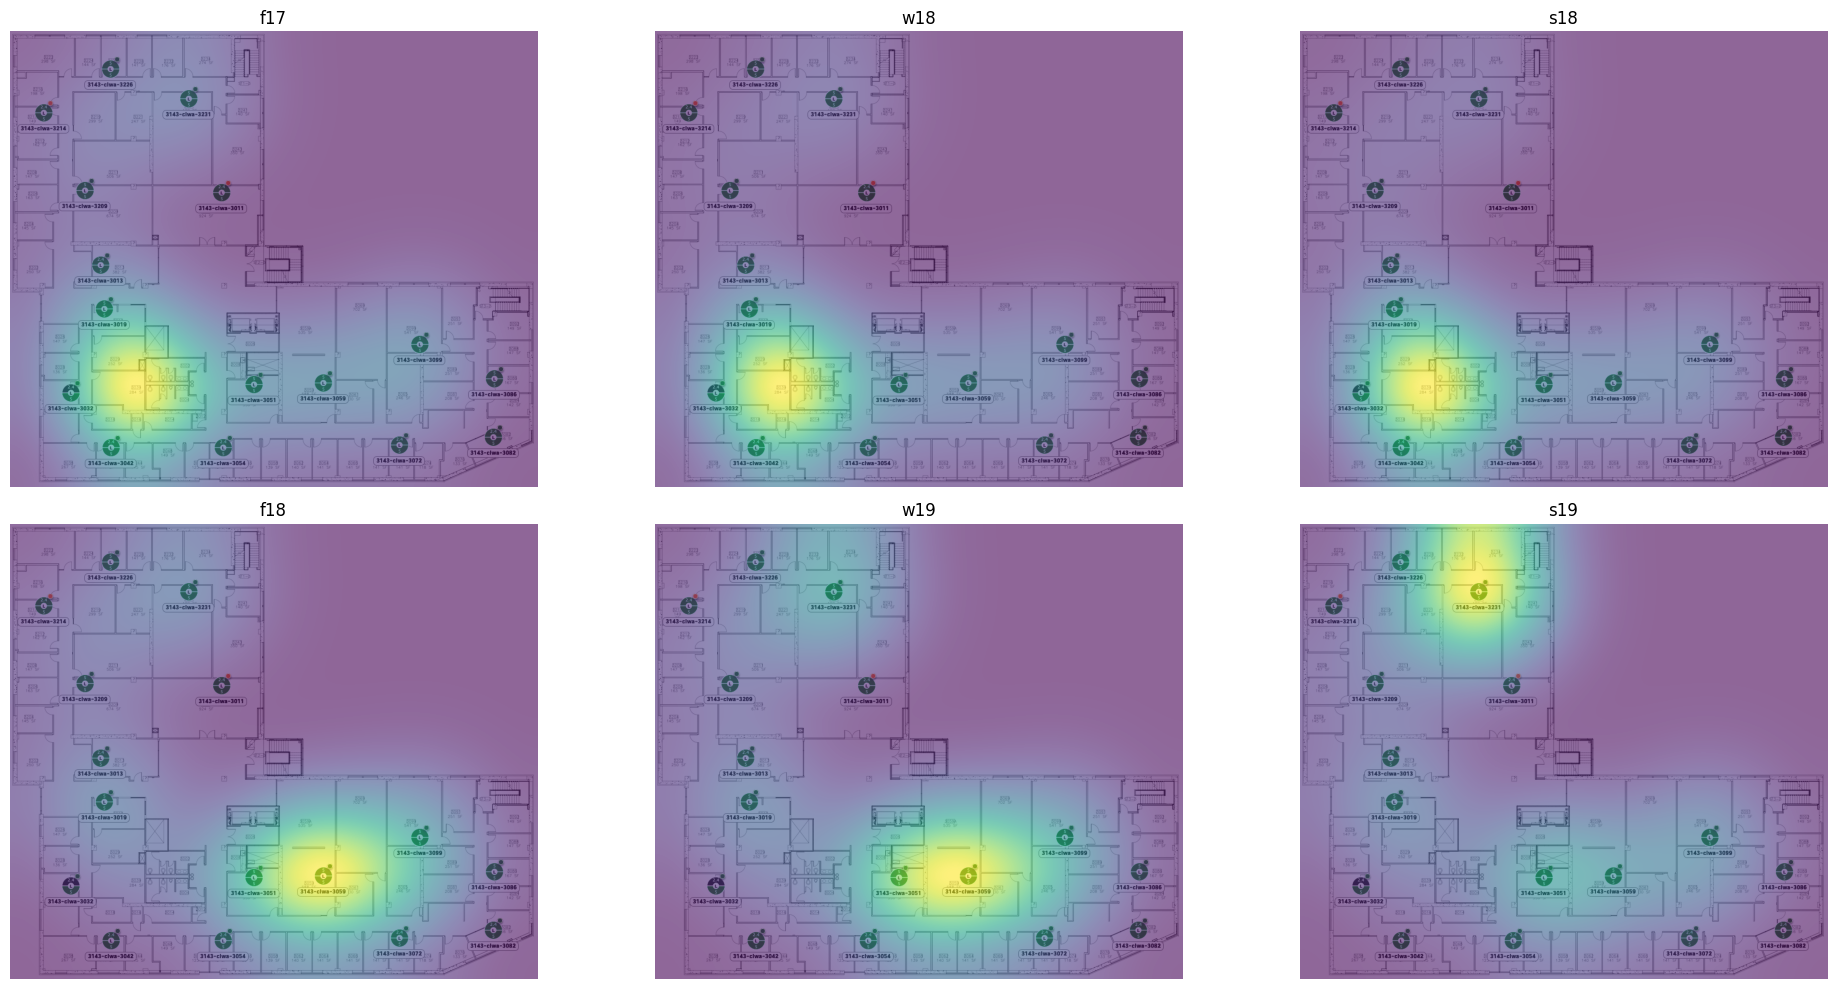

{'3144-clwa-4209': 283953, '3144-clwa-4219': 76657, '3144-clwa-4051': 68898, '3144-clwa-4019': 58281, '3144-clwa-4231': 45651, '3144-clwa-4059': 31353, '3144-clwa-4065': 18308, '3144-clwa-4099': 17416, '3144-clwa-4039': 13661}
{'3144-clwa-4209': 181725, '3144-clwa-4019': 90259, '3144-clwa-4051': 78614, '3144-clwa-4231': 78521, '3144-clwa-4059': 38730, '3144-clwa-4065': 37777, '3144-clwa-4219': 32534, '3144-clwa-4099': 26217, '3144-clwa-4039': 14152}
{'3144-clwa-4209': 87425, '3144-clwa-4019': 85645, '3144-clwa-4051': 75301, '3144-clwa-4231': 56013, '3144-clwa-4059': 40807, '3144-clwa-4065': 33037, '3144-clwa-4099': 27285, '3144-clwa-4219': 25620, '3144-clwa-4039': 14262}
{'3144-clwa-4231': 253874, '3144-clwa-4019': 73939, '3144-clwa-4051': 60454, '3144-clwa-4209': 46780, '3144-clwa-4065': 30525, '3144-clwa-4059': 24224, '3144-clwa-4219': 22672, '3144-clwa-4039': 19442, '3144-clwa-4099': 19055}
{'3144-clwa-4231': 131175, '3144-clwa-4019': 75304, '3144-clwa-4051': 73335, '3144-clwa-4209'

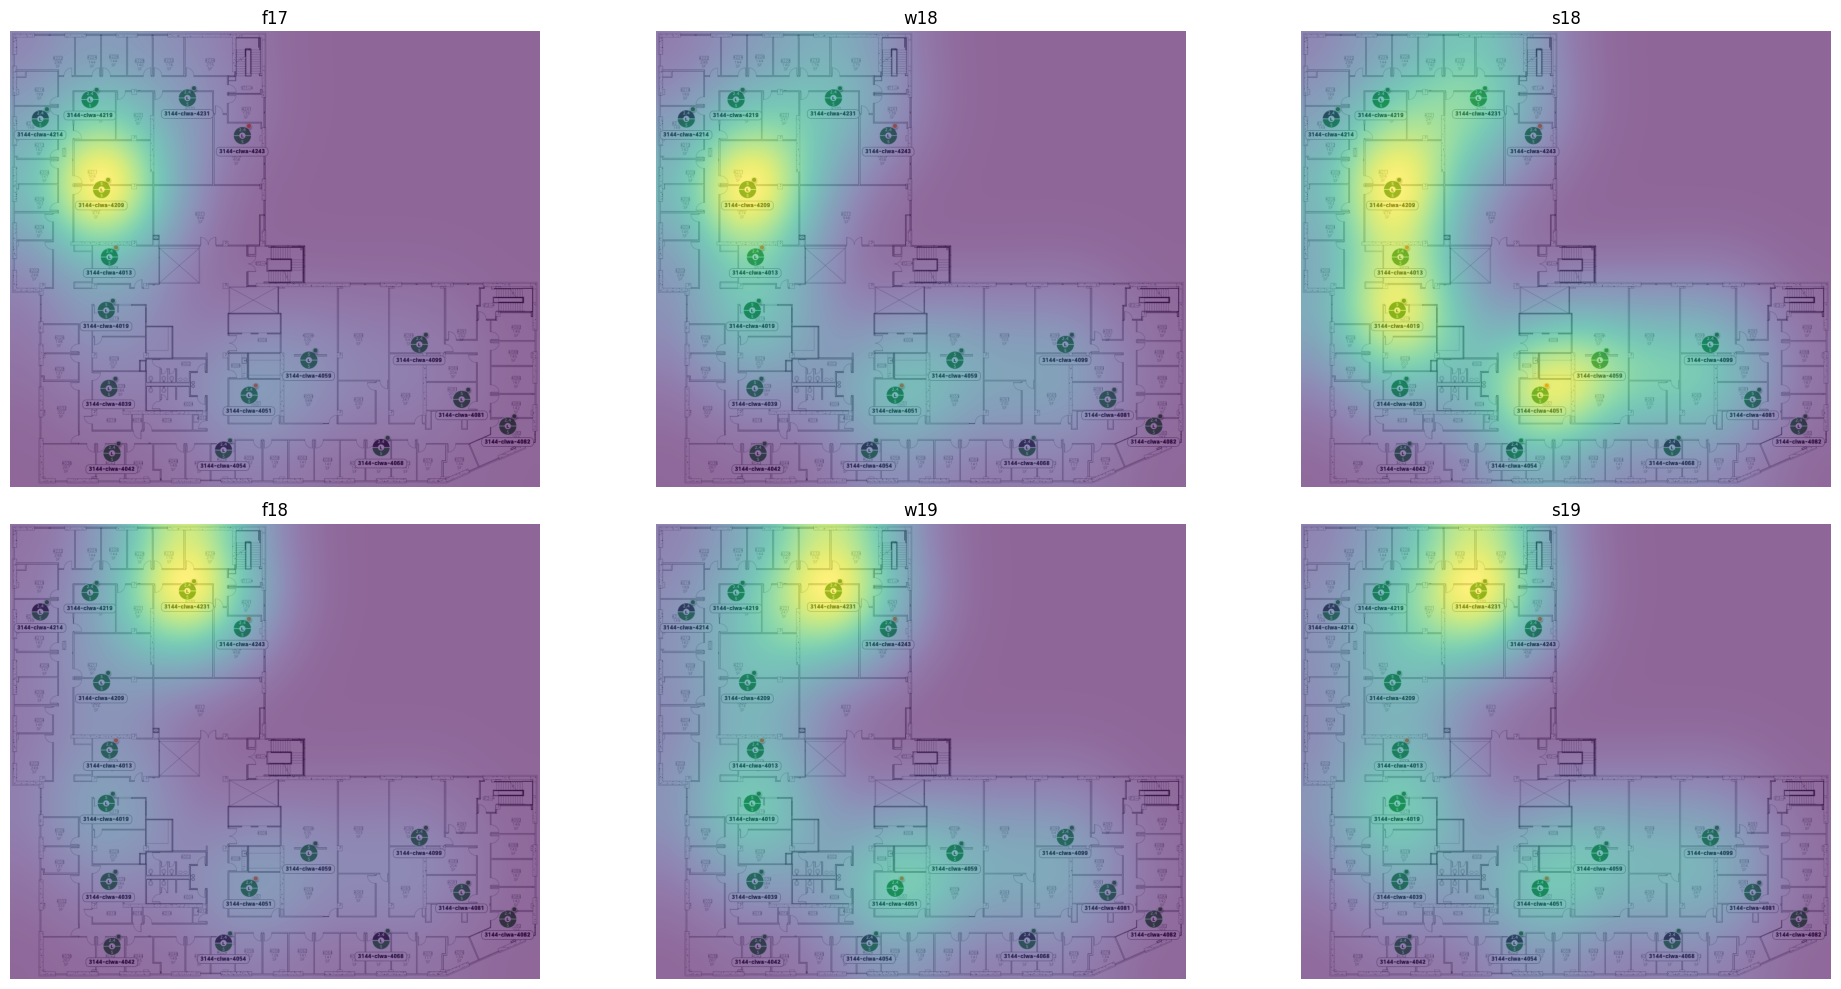

{'3145-clwa-5019': 170161, '3145-clwa-5065': 36513, '3145-clwa-5231': 35587, '3145-clwa-5051': 25539, '3145-clwa-5209': 22624, '3145-clwa-5039': 20446, '3145-clwa-5219': 19092, '3145-clwa-5099': 17987, '3145-clwa-5059': 13234}
{'3145-clwa-5019': 247798, '3145-clwa-5231': 46461, '3145-clwa-5065': 41359, '3145-clwa-5051': 27310, '3145-clwa-5209': 27187, '3145-clwa-5039': 27066, '3145-clwa-5219': 20690, '3145-clwa-5099': 20049, '3145-clwa-5059': 16702}
{'3145-clwa-5019': 250130, '3145-clwa-5065': 43225, '3145-clwa-5209': 36330, '3145-clwa-5219': 33714, '3145-clwa-5231': 33184, '3145-clwa-5051': 30465, '3145-clwa-5039': 22924, '3145-clwa-5099': 19057, '3145-clwa-5059': 18729}
{'3145-clwa-5019': 64054, '3145-clwa-5231': 45599, '3145-clwa-5065': 44382, '3145-clwa-5059': 42664, '3145-clwa-5209': 34591, '3145-clwa-5051': 24716, '3145-clwa-5219': 23856, '3145-clwa-5039': 17909, '3145-clwa-5099': 11279}
{'3145-clwa-5059': 141432, '3145-clwa-5019': 109375, '3145-clwa-5065': 58671, '3145-clwa-5231

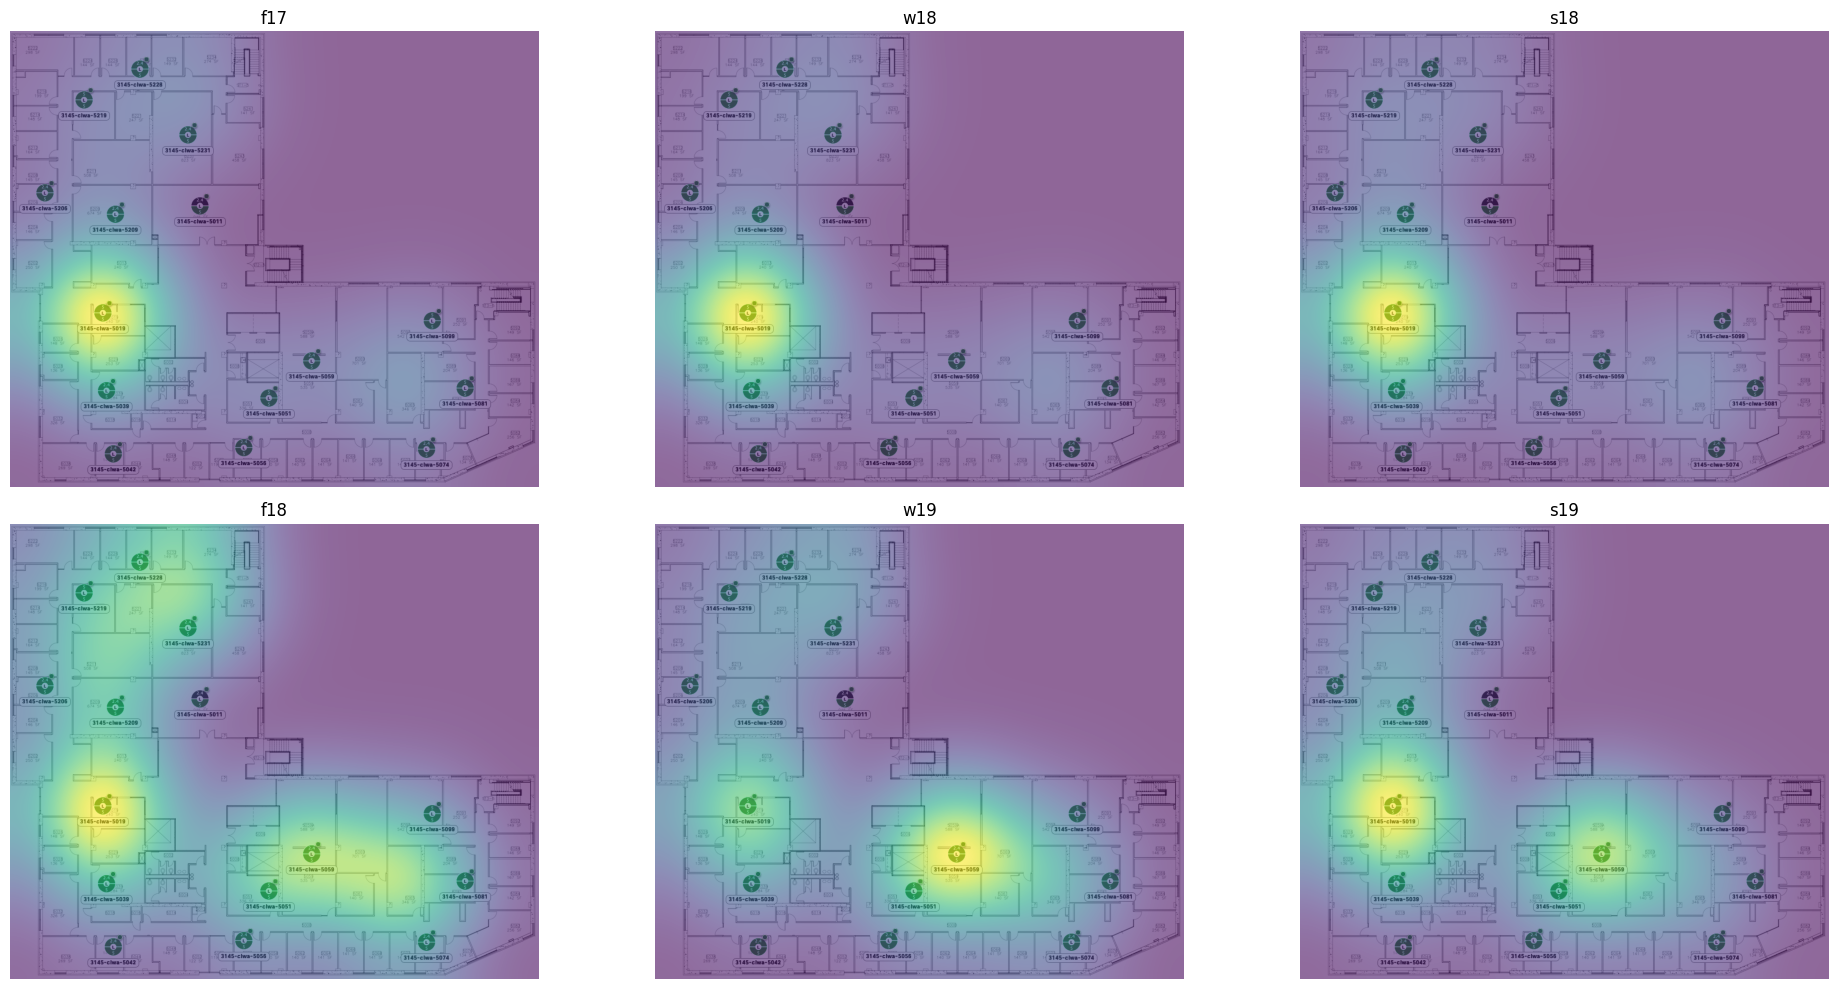

{'3146-clwa-6122': 180114, '3146-clwa-6029': 91229, '3146-clwa-6049': 87439, '3146-clwa-6011': 86000, '3146-clwa-6131': 31538, '3146-clwa-6217': 19435, '3146-clwa-6219': 13327}
{'3146-clwa-6122': 177421, '3146-clwa-6131': 177281, '3146-clwa-6029': 107372, '3146-clwa-6011': 102125, '3146-clwa-6049': 44281, '3146-clwa-6217': 30857, '3146-clwa-6219': 11723}
{'3146-clwa-6122': 227673, '3146-clwa-6131': 140823, '3146-clwa-6029': 117268, '3146-clwa-6011': 97733, '3146-clwa-6049': 51638, '3146-clwa-6217': 36022, '3146-clwa-6219': 10709}
{'3146-clwa-6122': 162046, '3146-clwa-6131': 104153, '3146-clwa-6011': 88337, '3146-clwa-6029': 69184, '3146-clwa-6049': 41789, '3146-clwa-6217': 23293, '3146-clwa-6219': 10503}
{'3146-clwa-6122': 173676, '3146-clwa-6029': 102597, '3146-clwa-6131': 79305, '3146-clwa-6011': 77133, '3146-clwa-6049': 67742, '3146-clwa-6217': 24656, '3146-clwa-6219': 11699}
{'3146-clwa-6122': 32769, '3146-clwa-6049': 14559, '3146-clwa-6029': 12902, '3146-clwa-6011': 11636, '3146-c

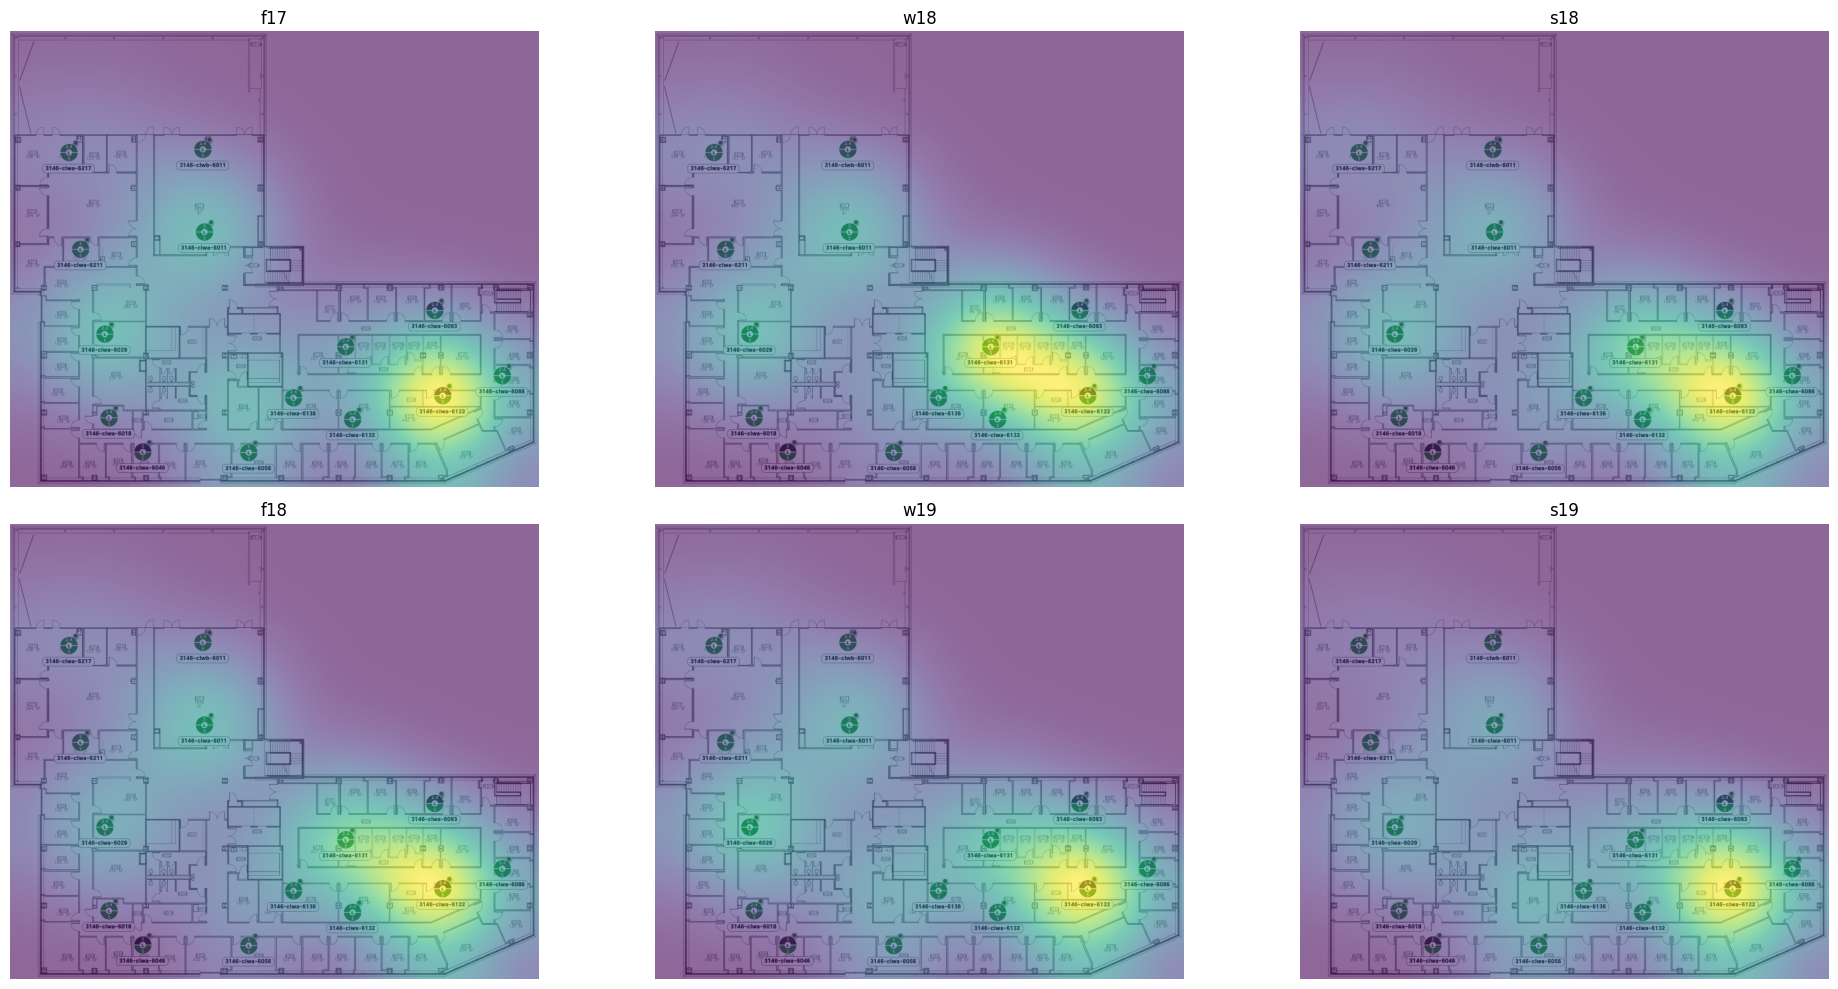

In [11]:
for i in range(1, 7):
    generate_heatmaps(df_processed_data, i, "viridis")